# Importing the dependency

In [1]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
#stopwords are commonly dropped in text preprocessing beacuse they carry little meaningful information
# Example usage of NLTK's stopwords
print(stopwords.words('english'))

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

# Data Processing

In [3]:
#loading the data from csv  file to pandas dataframe
twitter_data = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding = 'ISO-8859-1', header=None) 

In [4]:
twitter_data.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
#checking the number of rows and columns in the data frame
twitter_data.shape

(1600000, 6)

In [6]:
#naming the columns
twitter_data.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
 

In [7]:
#chacking the columns names
twitter_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [8]:
twitter_data.shape

(1600000, 6)

In [9]:
#chaecking for missing values
twitter_data.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [10]:
#chaecking the distribution of target variable
twitter_data['target'].value_counts()

target
0    800000
4    800000
Name: count, dtype: int64

In [11]:
#converting the target variable to 0 and 1
#0 --- negative
#1 --- positive
twitter_data['target'] = twitter_data['target'].replace(4,1)

In [12]:
#chaecking the distribution of target variable
twitter_data['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

C:\Users\rahul\AppData\Local\Temp\ipykernel_28116\4067840469.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=twitter_data['target'], palette= ['red', 'green'])


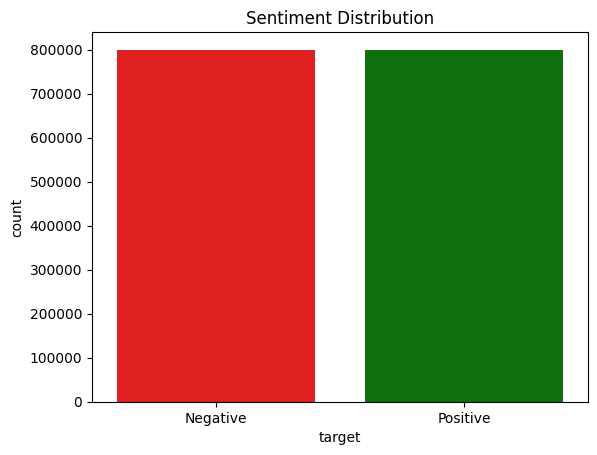

In [16]:
#distribution of target variable
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=twitter_data['target'], palette= ['red', 'green'])
plt.xticks([0,1], ["Negative", "Positive"])
plt.title("Sentiment Distribution")
plt.show()

In [17]:
#cleaning the text data by removing unwanted Urls,mentions,Hashtags,non-alphanumeric characters,exta spaces and capital letters.
def clean_text(text):
    text = re.sub(r'http\S+', '', text)   # remove URLs
    text = re.sub(r'@\w+', '', text)      # remove mentions
    text = re.sub(r'#\w+', '', text)      # remove hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text) # keep only letters
    text = text.lower().strip()           # lowercase and trim BEFORE splitting
    words = text.split()                  # split into words
    words = [word for word in words if word not in stopwords.words('english')]  # remove stopwords
    return ' '.join(words)



In [18]:
#cleaning the text column
twitter_data['text'] = twitter_data['text'].apply(clean_text)

In [19]:
# Save the DataFrame as a pickle file
twitter_data.to_pickle("twitter_data.pkl")

In [20]:
# Later, you can load it back with:
loaded_data = pd.read_pickle("twitter_data.pkl")

In [21]:
loaded_data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats bummer shoulda got david carr third...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save rest go bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,behaving im mad cant see


In [ ]:
#stemming
ps = PorterStemmer()
def stemming(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in stopwords.words('english')]
    text = ' '.join(text)
    return text

In [ ]:
twitter_data['stemmed_text'] = twitter_data['text'].apply(stemming)

In [ ]:
text = "Modi was born and raised in Vadnagar, Bombay State (present-day Gujarat), where he completed his secondary education. He was introduced to the RSS at the age of eight. Modi became a full-time worker for the RSS in Gujarat in 1971. The RSS assigned him to the BJP in 1985 and he rose through the party hierarchy, becoming general secretary in 1998.[b] In 2001, Modi was appointed chief minister of Gujarat and elected to the legislative assembly soon after. His administration is considered complicit in the 2002 Gujarat riots,[c] and has been criticised for its management of the crisis. According to official records, a little over 1,000 people were killed, three-quarters of whom were Muslim; independent sources estimated 2,000 deaths, mostly Muslim.[4] A Special Investigation Team appointed by the Supreme Court of India in 2012 found no evidence to initiate prosecution proceedings against him.[d] While his policies as chief minister were credited for encouraging economic growth, his administration was criticised for failing to significantly improve health, poverty and education indices in the state."

In [ ]:
text = text.split()
print(text)

In [ ]:
text = ''.join(text)
print(text)